# Installing and Importing Required Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
import random
from PIL import Image
import matplotlib.pyplot as plt

Mounted at /content/drive


# Load Dataset

In [2]:
dataset_path = "/content/drive/MyDrive/BTP/times_new_roman_dataset"
csv_path = "labelsReg.csv"

In [3]:
import pandas as pd
data = pd.read_csv(csv_path)
print(data.head())

                     filename  font_size
0  Times_New_Roman_10px_0.png         10
1  Times_New_Roman_11px_0.png         11
2  Times_New_Roman_13px_0.png         13
3  Times_New_Roman_14px_0.png         14
4  Times_New_Roman_16px_0.png         16


# Data Preprocessing

In [4]:
images = []
font_sizes = []

for index, row in data.iterrows():
    image_path = os.path.join(dataset_path, row['filename'])

    if os.path.exists(image_path):
        img = Image.open(image_path).convert("L")
        img = img.resize((32, 32))
        img = np.array(img) / 255.0

        images.append(img)
        font_sizes.append(row['font_size'])

images = np.array(images).reshape(-1, 32, 32, 1)
font_sizes = np.array(font_sizes)

x_train, x_test, y_train, y_test = train_test_split(images, font_sizes, test_size=0.2, random_state=42)

scaler = MinMaxScaler()

y_train = scaler.fit_transform(y_train.reshape(-1, 1))
y_test = scaler.transform(y_test.reshape(-1, 1))

# Build CNN Regression Model


In [5]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

def create_lenet_regression():
    model = models.Sequential([
        layers.Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 1), padding='valid',
                      kernel_initializer=tf.keras.initializers.HeNormal(seed=SEED)),

        layers.AveragePooling2D((2, 2)),

        layers.Conv2D(16, (5, 5), activation='relu', padding='valid',
                      kernel_initializer=tf.keras.initializers.HeNormal(seed=SEED)),

        layers.AveragePooling2D((2, 2)),

        layers.Flatten(),

        layers.Dense(120, activation='relu',
                     kernel_initializer=tf.keras.initializers.HeNormal(seed=SEED)),

        layers.Dense(84, activation='relu',
                     kernel_initializer=tf.keras.initializers.HeNormal(seed=SEED)),

        layers.Dense(1,
                     kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED))
    ])

    return model

model = create_lenet_regression()

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=MeanSquaredError(),
              metrics=['mae'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 6)           │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 14, 14, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 5, 5, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,941 (238.05 KB)

 Trainable params: 60,941 (238.05 KB)

 Non-trainable params: 0 (0.00 B)

# Train the Model


In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=8,
    callbacks=[early_stopping, reduce_lr]
)

loss, mae = model.evaluate(x_test, y_test)
print(f"Test MAE: {mae:.2f} px")

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.2875 - mae: 0.4302 - val_loss: 0.2837 - val_mae: 0.5138 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1899 - mae: 0.3602 - val_loss: 0.0208 - val_mae: 0.1226 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0759 - mae: 0.2454 - val_loss: 0.0249 - val_mae: 0.1249 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0514 - mae: 0.1902 - val_loss: 0.0305 - val_mae: 0.1316 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0461 - mae: 0.1860 - val_loss: 0.0153 - val_mae: 0.1114 - learning_rate: 0.0010
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0335 - mae: 0.1610 - val_loss: 0.0199 - val_mae: 0.1028 - learning_rate: 0.0010
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0241 - mae: 0.1197 - val_loss: 0.0109 - val_mae: 0.0935 - learning_rate: 0.0010
Epoch 8/50
4/4 ━━━━━━━━━━━

In [7]:
y_pred = model.predict(x_test)

y_pred = scaler.inverse_transform(y_pred)

y_test_original = scaler.inverse_transform(y_test)

print("Actual vs Predicted Font Sizes:")
for actual, predicted in zip(y_test_original.flatten(), y_pred.flatten()):
    print(f"Actual: {actual:.2f}  |  Predicted: {predicted:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Actual vs Predicted Font Sizes:
Actual: 49.00  |  Predicted: 50.84
Actual: 29.00  |  Predicted: 29.51
Actual: 46.00  |  Predicted: 46.65
Actual: 41.00  |  Predicted: 41.89
Actual: 32.00  |  Predicted: 30.71
Actual: 53.00  |  Predicted: 53.11
Actual: 38.00  |  Predicted: 40.91


# Training History

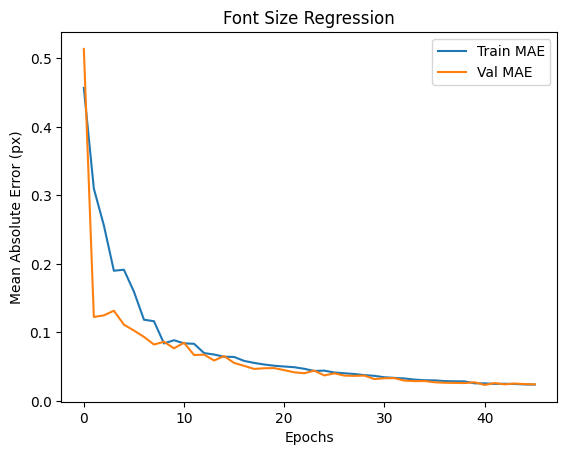

In [8]:
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (px)')
plt.title('Font Size Regression')
plt.show()
